# Imports

In [3]:
# System and OS
import sys,os

# Data types
import datetime

# Basic numeric/data analysis and viz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib

# Advanced data analysis
import sklearn as sk


# Constants & Params

In [4]:
# Paths for data and visualization
DATA_PATH = '../data'
VIZ_PATH = '../viz'

# Paths for data Hopkins Y INS
HOPKINS_PATH = 'hopkins'
INS_PATH = 'ins'
OWID_PATH = 'owid'
# Fonts for matplotlib
LARGE_SIZE = 20
SMALL_SIZE = 17
SSSMALL_SIZE = 12
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

# Latex fonts
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'

# Data Loading & Structure [Testing Our world in Data]
Data obtained on https://github.com/owid/covid-19-data/tree/master/public/data/

In [5]:
# Confirmed_cases
owid_tested = pd.read_csv(f'{DATA_PATH}/{OWID_PATH}/'+
                          f'owid-covid-data.csv',
                          skiprows=0)
owid_tested[owid_tested['iso_code']=='COL'].head(2)

,iso_code,location,date,total_cases,new_cases,total_deaths,new_deaths,total_cases_per_million,new_cases_per_million,total_deaths_per_million,...,aged_65_older,aged_70_older,gdp_per_capita,extreme_poverty,cvd_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_100k
4172,COL,Colombia,2020-03-05,0,0,0,0,NaN,NaN,NaN,...,7.646,4.312,13254.949,4.5,124.24,7.44,4.7,13.5,65.386,1.71
4173,COL,Colombia,2020-03-06,0,0,0,0,NaN,NaN,NaN,...,7.646,4.312,13254.949,4.5,124.24,7.44,4.7,13.5,65.386,1.71


# Data Loading & Structure [John Hopkins]
Data obtained on https://data.humdata.org/dataset/novel-coronavirus-2019-ncov-cases

In [6]:
# Confirmed_cases
jh_confirmed = pd.read_csv(f'{DATA_PATH}/{HOPKINS_PATH}/'+
                           f'time_series_covid19_confirmed_global_iso3_regions.csv',
                           skiprows=[1])
# Deaths
jh_deaths = pd.read_csv(f'{DATA_PATH}/{HOPKINS_PATH}/'+
                           f'time_series_covid19_deaths_global_iso3_regions.csv',
                           skiprows=[1])
# Recovered
jh_recovered = pd.read_csv(f'{DATA_PATH}/{HOPKINS_PATH}/'+
                           f'time_series_covid19_recovered_global_iso3_regions.csv',
                           skiprows=[1])

# Peek at Data structure
jh_confirmed.head(2)

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/21/20,4/22/20,4/23/20,ISO 3166-1 Alpha 3-Codes,Region Code,Region Name,Sub-region Code,Sub-region Name,Intermediate Region Code,Intermediate Region Name
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,1092,1176,1279,AFG,142.0,Asia,34.0,Southern Asia,NaN,NaN
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,609,634,663,ALB,150.0,Europe,39.0,Southern Europe,NaN,NaN


# Pivot
For better manipulation, data must be unpivoted to obtain time series as a column. It occupies more space that way, which may be the reason for this format on source pages.

In [7]:
@np.vectorize
def str_to_date(date_str:str):
    """
    Converts a string to datetime.date in the format 'm/d/yy'

    Keyword arguments:
    date_str -- The date in string format
    
    Returns:
    date_dt -- The date in datetime.date data type
    """
    date_split = date_str.split('/')
    return datetime.date( day=int(date_split[1])
                         ,month=int(date_split[0])
                         ,year=int('20'+date_split[2]))

def pivot_time_series( df:pd.DataFrame
                      ,val_name:str = 'Value'):
    """
    Pivot dataframe time series into a column of dates and values

    Keyword arguments:
    df -- The dataframe to pivot
    val_name -- The names of the values (default 'value')
    
    Returns:
    df -- The pivoted dataframe
    """
    
    # Retrieve date columns
    date_cols = [col for col in df.columns if col.count('/')==2]
    # Indentifier columns
    id_cols = [col for col in df.columns if col not in date_cols]
    
    # Performs a pivot
    df = df.melt(id_vars = id_cols, 
                 value_vars = date_cols,
                 var_name = 'Date',
                 value_name = val_name)
    
    df = df[df['Value'] > 0]
    # Converts to datetime
    df['Date'] = df['Date'].map(str_to_date)
    
    # Calculates
    df['Days Since First Case'] = df.groupby(['ISO 3166-1 Alpha 3-Codes'])[['Date']].transform('min')
    df['Days Since First Case'] = (df['Date'] - df['Days Since First Case']).map(lambda x:x.days)

        # Changes column name
    df = df.rename(columns={'ISO 3166-1 Alpha 3-Codes':'Country Code'})
    
    
    # Returns dataframe
    return df

In [8]:
# Unpivot dataframes
jh_confirmed = pivot_time_series(jh_confirmed)
jh_deaths = pivot_time_series(jh_deaths)
jh_recovered = pivot_time_series(jh_recovered)

# Differentiation to obtain multiplication times
In the context of cumulative counting functions, the slope of the time series in logarithmic scale is directly related to the multiplication period. This is easy to verify assuming local lineal behavior of the logarithmic function, which is equivalent to local exponential behavior of its natural counterpart:

$$Ln(y)=mt + b \rightarrow y = y_0 e^{mt}$$
$$\frac{d Ln(y)}{dt} = m $$

We can relate this slope $m$ to the specific doubling time $\tau$:
$$y(t+\tau) = 2y(t)$$
$$y_0 e^{m(t+\tau)} = 2 y_0 e^{mt}$$
$$e^{m\tau} = 2$$
$$\tau = \frac{Ln(2)}{m}$$

In [9]:
# Defines a function that returns the doubling time 
def get_doubling_time(df):
    
    # Sorts values by dates
    df = df.sort_values(by='Date')
    
    # Gets nonzero values mask
    non_zero_mask = df['Value']!=0
    
    # Gets the derivative (second order error derivative) mid point rule
    derivative_log = 0.5*((df.loc[non_zero_mask,'Value'].values[2:]-
                           df.loc[non_zero_mask,'Value'].values[:-2])/
                          df.loc[non_zero_mask,'Value'].values[1:-1])  
    
    # Asigns derivative to a new column
    derivatives_log = np.zeros(len(df.index))*np.nan
    derivatives_log[non_zero_mask] = np.array([np.nan]+list(derivative_log)+[np.nan])
    df['Derivative'] = derivatives_log
    
    # Calculates doubling times
    df['Doubling Time'] = np.nan
    df.loc[~df['Derivative'].isna(),'Doubling Time'] = np.log(2)/df.loc[df['Derivative']!=0,'Derivative']

    # Calculates doubling times
    df['Doubling Time Smoothened'] = np.nan
    # Smoothen signals with savgol filter
    from scipy.signal import savgol_filter
    y = savgol_filter(df.loc[~df['Doubling Time'].isna(),'Doubling Time'].values,9,1)
    df.loc[~df['Doubling Time'].isna(),'Doubling Time Smoothened'] = y
    
    # Calculates doubling times    
    df['Derivative'] = 100*df['Derivative']
    
    # Returns df
    return df


In [10]:
# Gets duplication times for each country
countries = ['BRA','CHL','COL','ECU','DEU','ITA','MEX','PER','ESP','GBR','KOR','JPN','USA']
countries = ['BRA','CHL','COL','MEX','PER','USA','ECU','ARG','DEU','ITA']
total_dfs = []
for country in countries:
    df_app = get_doubling_time(jh_confirmed[jh_confirmed['Country Code'] == country])
    df_app = df_app[[ 'Country/Region'
                     ,'Country Code'
                     ,'Date'
                     ,'Value'
                     ,'Doubling Time'
                     ,'Doubling Time Smoothened','Days Since First Case']]
    total_dfs.append(df_app)
doubling_time_dfs = pd.concat(total_dfs)

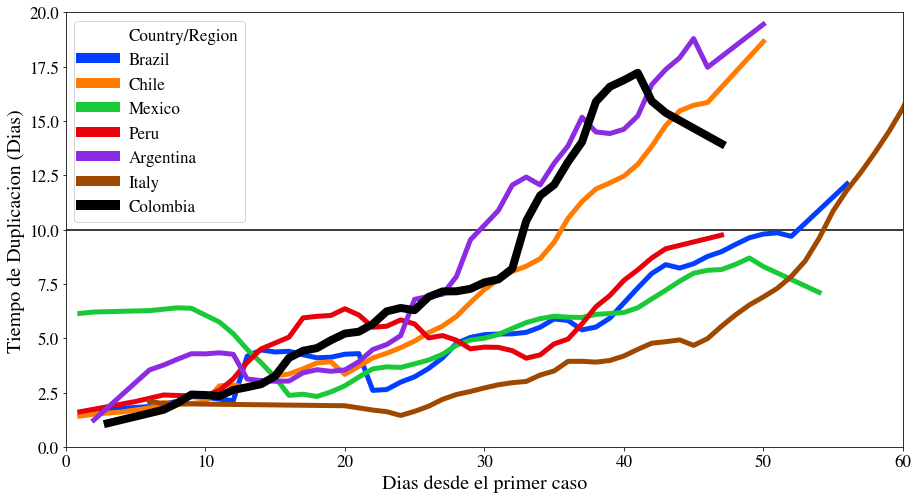

In [11]:
from matplotlib.ticker import MaxNLocator
import matplotlib.dates as mdates
sns.set_palette('bright')

# Plots duplication times accross different countries
def plot_dup_times(countries_reg,fig_name,data):
    # Figure
    fig = plt.figure(figsize=(15,8))

    # Plots curves
    sns.lineplot( x='Days Since First Case'
                 ,y='Doubling Time Smoothened'
                 ,data=data[data['Country/Region'].isin(countries_reg)&(data['Country/Region']!='Colombia')]
                 ,hue='Country/Region'
                 ,linewidth=5)
    sns.lineplot( x='Days Since First Case'
                 ,y='Doubling Time Smoothened'
                 ,data=data[data['Country/Region']=='Colombia']
                 ,color='black'
                 ,label = 'Colombia'
                 ,linewidth=8)    
    # H line for reference
    plt.hlines(10,data['Days Since First Case'].min(),data['Days Since First Case'].max())

    # Plots legend
    plt.legend(loc='best')

    # gets legend
    leg = plt.gca().legend()
    # Line thicknes in legend
    for line in leg.get_lines():
        line.set_linewidth(10)

    # Customize Axes lims
    #plt.xlim(datetime.date(2020,3,1),data['Days Since First Case'].max())
    # Ticks rotation
    #plt.xticks(rotation=15)
    # Integer ticks
    #plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))
    # Custom ticks for x axis
    #plt.gca().xaxis.set_major_locator(mdates.weekLocator())

    # Axes labels
    plt.xlabel('Dias desde el primer caso')
    plt.ylabel('Tiempo de Duplicacion (Dias)')
    
    plt.ylim(0,20)
    plt.xlim(0,60)
    # Save fig
    plt.savefig(f'{VIZ_PATH}/{fig_name}.png')

# Countries
#countries_reg = ['Mexico','Colombia','Brazil','Chile','Peru']
#plot_dup_times(countries_reg,'Tiempo de Duplicacion LATAM',doubling_time_dfs)
# Countries
#countries_reg = [ 'Germany'
#                 ,'United Kingdom'
#                 ,'Italy'
#                 ,'France'
#                 ,'Spain'
#                 ,'US'
#                 ,'Japan']
                 #,'Korea, South']
#plot_dup_times(countries_reg,'Tiempo de Duplicacion Mundo',doubling_time_dfs)
plot_dup_times(['Mexico','Colombia','Brazil','Chile','Peru','Argentina','Italy'],'Tiempo de Duplicacion Final',doubling_time_dfs)

# How much time did it take for each country to reach 10 days of Case duplication?
To measure how fast did each country act over the sanitary emergency, we calculate how much did it take for each country to reach a certain number of days of duplication of cases. We take this quantity of days for multiplication as a measure of how fast is the virus spreading, taking $n>10 days$ as slowly spreading (partially controlled) and $n<10$ as rapidly spreading (poorly controlled). The reason for the choice of this exact number is to make the analysis possible for LATAM countries, which are still at an early stage of the crisis. While the definition of how controlled is the virus may vary from country to country according to its logistic/health-care system capacities, we do not take this into account yet as it requires further sophistication for this quick analysis.

One may also argue that taking the detected cases for each country may bias the analysis as one cannot state the level of control over a pandemic that is partially unknown. However, If we assume that the unknown cases are a constant proportion (per country) of the total cases at all times, the duplication times are the same for detected cases and for the total cases. Stating that the unknown cases are a constant proportion of the total cases for each country is a strong assumption, however, if the strategy of test sampling is stable in a country, it is not an absurd assumption, after all, only a fraction of infected cases develop symptoms strong enough to get tested. This also relies in a consistency of test sampling. Further rigor in this study is left for future studies. 

To treat the noise at the beginning of the crisis in each country, we take the start of the infection as the date of the first death in each country.

In [59]:
import math

# Calculates the time it took from the first case to controlling the infection
# Controlling date defined as the first date of duplication time above 10 days
def control_time_date(df_cases_dup,df_deaths,country,date_nan):
    # Mask for the country in the cases DF
    mask_cases = df_cases_dup['Country Code']==country
    # Mask for the country in the cases DF
    mask_deaths = df_deaths['Country Code']==country
    
    # First calculate the first death
    first_death = df_deaths.loc[mask_deaths&(df_deaths['Value']>0),
                                'Date'].min()
    
    # Initial controlling is noisy so we only search for control dates after first date
    mask_control_date = df_cases_dup['Date']>=first_death
    
    # Then calculates the first date for Duplication time above 10 days
    control_time = df_cases_dup.loc[mask_cases&mask_control_date&
                                    (df_cases_dup['Doubling Time Smoothened']>10),
                                    'Date'].min()
    # if control time is nan then it assigns a specific date
    if str(type(control_time))!="<class 'datetime.date'>":
        control_time = date_nan
    
    # Deaths the country had when it controlled the infection
    deaths = df_deaths.loc[ mask_deaths&(df_cases_dup['Date']<=control_time)
                           ,'Value'].max()
    
    # Returns the values
    return country,first_death,control_time,(control_time-first_death).days,deaths

# Obtain values for  each country and keeps it in a list
vals_country_list = []
# Country codes
country_codes = ['BRA','CHL','COL','DEU','ITA','MEX','PER','ESP','GBR','KOR','JPN','USA']
country_codes = ['BRA','CHL','COL','MEX','PER','USA','ECU','ARG','DEU','ITA']
for country in country_codes:
    vals_country_list.append(list( control_time_date( doubling_time_dfs
                                                     ,jh_deaths
                                                     ,country
                                                     ,datetime.date(2020,4,30))))

# Creates dataframe
dates = pd.DataFrame({ 'Pais':[x[0] for x in vals_country_list]
                      ,'Fecha Primera Muerte':[x[1] for x in vals_country_list]
                      ,'Fecha Apaciguamiento':[x[2] for x in vals_country_list]
                      ,'Dias Tomados en Apaciguar':[x[3] for x in vals_country_list]
                      ,'Muertes al Momento de Apaciguamiento':[x[4] for x in vals_country_list]
                      ,'Dias en Tomar Medidas':['' for x in vals_country_list]})
dates.sort_values(by='Dias Tomados en Apaciguar')

,Pais,Fecha Primera Muerte,Fecha Apaciguamiento,Dias Tomados en Apaciguar,Muertes al Momento de Apaciguamiento,Dias en Tomar Medidas
1,CHL,2020-03-22,2020-04-08,17,48,
2,COL,2020-03-22,2020-04-08,17,54,
6,ECU,2020-03-14,2020-04-01,18,93,
8,DEU,2020-03-09,2020-04-01,23,920,
7,ARG,2020-03-08,2020-04-02,25,36,
0,BRA,2020-03-17,2020-04-19,33,2462,
9,ITA,2020-02-21,2020-03-26,34,8215,
5,USA,2020-02-29,2020-04-09,40,16544,
4,PER,2020-03-20,2020-04-30,41,572,
3,MEX,2020-03-19,2020-04-30,42,1069,


# The classic death to infected ratio (CFR)

In [60]:
def death_infected_ratio(df_cases,df_deaths,country):
    # Mask for the country in the cases DF
    mask_cases = df_cases['Country Code']==country
    # Mask for the country in the cases DF
    mask_deaths = df_deaths['Country Code']==country
    
    # Dates Cases (We need cases to calculate the ratio)
    dates_cases = df_cases.loc[mask_cases&(df_cases['Value']>0),
                               'Date']
    
    # Actualize masks to include these dates
    mask_cases = mask_cases&(df_cases['Date'].isin(dates_cases))
    mask_deaths = mask_deaths&(df_deaths['Date'].isin(dates_cases))    
    
    # Creates dataframes for specific dates and countries with dates as indices
    df_cases_dates = df_cases.loc[mask_cases,[ 'Country Code'
                                              ,'Country/Region'
                                              ,'Date'
                                              ,'Value']].set_index('Date')    
    df_deaths_dates = df_deaths.loc[mask_deaths,[ 'Country Code'
                                                 ,'Country/Region'
                                                 ,'Date'
                                                 ,'Value']].set_index('Date')
    
    # The ratio
    df_cases_dates['Ratio Death Detected'] = 100*df_deaths_dates['Value']/df_cases_dates['Value']
    
    return df_cases_dates.reset_index()

In [61]:
# df Ratios
df_ratios = []
# iterates over countries obtaining ratios
for country in country_codes:
    df_ratios.append(death_infected_ratio(doubling_time_dfs,jh_deaths,country))

# Concatenates df ratios
df_ratios = pd.concat(df_ratios)


"# Countries\ncountries_reg = [ 'Germany'\n                 ,'United Kingdom'\n                 ,'Italy'\n                 ,'France'\n                 ,'Spain'\n                 ,'US'\n                 ,'Japan']\n                 #,'Korea, South']\nplot_ratio_death_detected(countries_reg,'CFR Mundo',df_ratios,datetime.date(2020,2,15))"

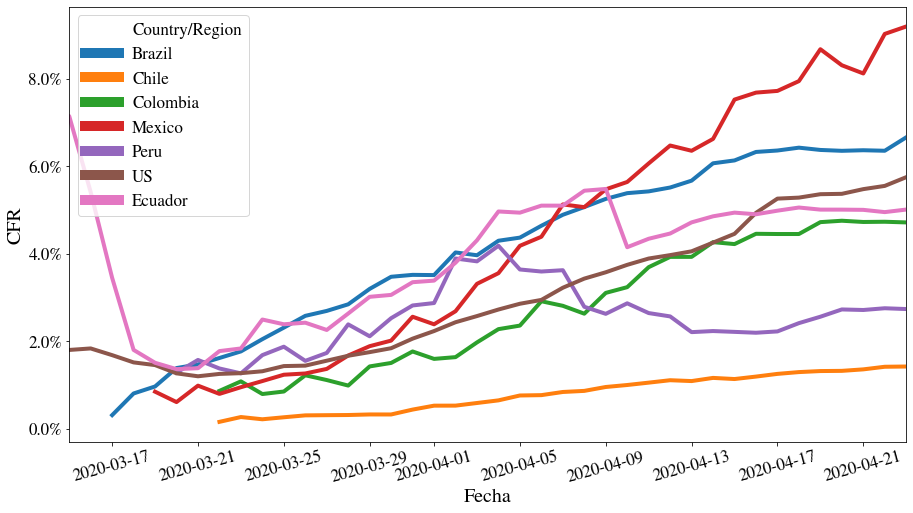

In [62]:
import matplotlib.ticker as mtick
def plot_ratio_death_detected(countries_reg,fig_name,data,min_date):
    # Figure
    fig = plt.figure(figsize=(15,8))

    # Plots curves
    sns.lineplot( x='Date'
                 ,y='Ratio Death Detected'
                 ,data=data[data['Country/Region'].isin(countries_reg)]
                 ,hue='Country/Region'
                 ,linewidth=4)

    # Plots legend
    plt.legend(loc='best')

    # gets legend
    leg = plt.gca().legend()
    # Line thicknes in legend
    for line in leg.get_lines():
        line.set_linewidth(10)

    # Customize Axes lims
    plt.xlim(min_date,data['Date'].max())
    # Ticks rotation
    plt.xticks(rotation=15)
    # Integer ticks
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=None))

    # Axes labels
    plt.xlabel('Fecha')
    plt.ylabel('CFR')

    # Save fig
    plt.savefig(f'{VIZ_PATH}/{fig_name}.png')

countries_reg = ['Mexico','Colombia','Brazil','Chile','Peru','Ecuador','US']
plot_ratio_death_detected(countries_reg,'CFR LATAM',df_ratios,datetime.date(2020,3,15))
'''# Countries
countries_reg = [ 'Germany'
                 ,'United Kingdom'
                 ,'Italy'
                 ,'France'
                 ,'Spain'
                 ,'US'
                 ,'Japan']
                 #,'Korea, South']
plot_ratio_death_detected(countries_reg,'CFR Mundo',df_ratios,datetime.date(2020,2,15))'''

In [14]:
jh_confirmed.loc[jh_confirmed['Country/Region'].isin(['Mexico',
                                                      'Colombia',
                                                      'Peru',
                                                      'Chile',
                                                      'Germany',
                                                      'United Kingdom',
                                                      'Ecuador',
                                                      'Brazil',
                                                      'Italy',
                                                      'France',
                                                      'Spain'
                                                      'United States of America']),
                 'Country Code'].unique()

array(['BRA', 'CHL', 'COL', 'ECU', 'GUF', 'PYF', 'GLP', 'MYT', 'NCL',
       'REU', 'BLM', 'MAF', 'MTQ', 'FRA', 'DEU', 'ITA', 'MEX', 'PER',
       'BMU', 'CYM', nan, 'GIB', 'IMN', 'MSR', 'GBR', 'AIA', 'VGB', 'TCA',
       'FLK', 'SPM'], dtype=object)

# Test positive case rate

In [48]:
# Calculates the positive case to Test ratio for each country/date
owid_tested['Ratio de Positivos por Test'] = 100*owid_tested['total_cases']/owid_tested['total_tests']

# Parse Dates to datetime format
owid_tested['date'] = owid_tested['date'].map(lambda x: datetime.date(*[int(y) for y in x.split('-')]))

In [30]:
def plot_ratio_positive_test(countries_reg,fig_name,data,min_date):
    # Figure
    fig = plt.figure(figsize=(15,8))

    # Plots curves
    sns.lineplot( x='date'
                 ,y='Ratio de Positivos por Test'
                 ,data=data[data['location'].isin(countries_reg)]
                 ,hue='location'
                 ,linewidth=4)

    # Plots legend
    plt.legend(loc='best')

    # gets legend
    leg = plt.gca().legend()
    # Line thicknes in legend
    for line in leg.get_lines():
        line.set_linewidth(10)

    # Customize Axes lims
    plt.xlim(min_date,data['date'].max())
    # Ticks rotation
    plt.xticks(rotation=15)
    # Integer ticks
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=None))

    # Axes labels
    plt.xlabel('Fecha')
    plt.ylabel('Ratio Casos Positivos por Tests')

    # Save fig
    plt.savefig(f'{VIZ_PATH}/{fig_name}.png')

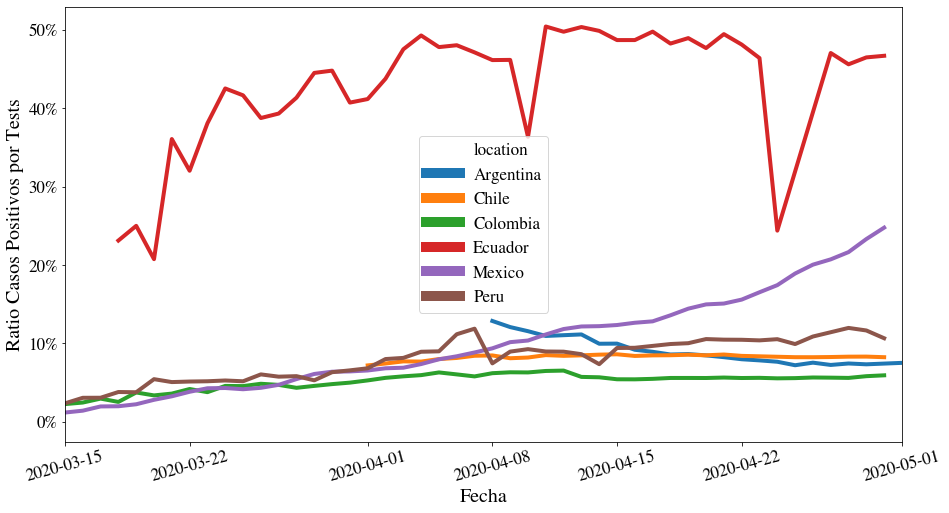

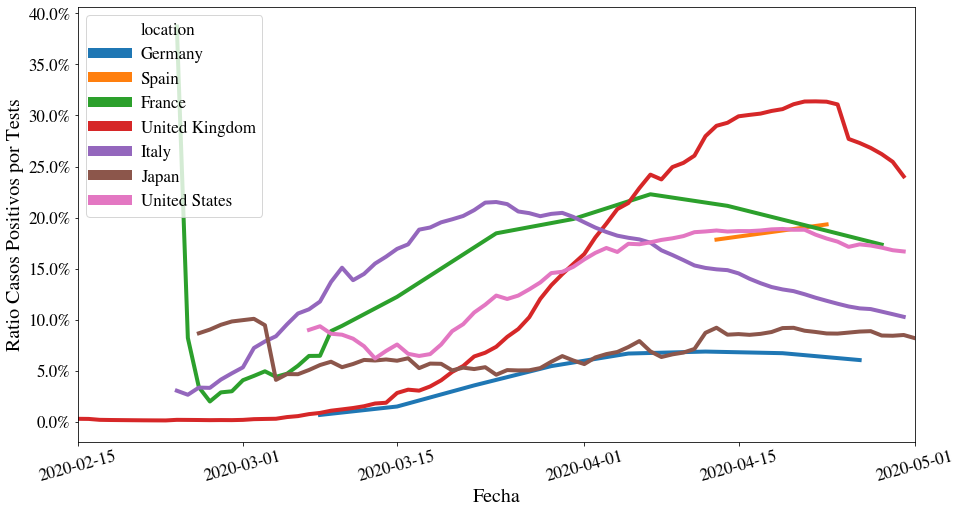

In [53]:
countries_reg = ['Mexico','Colombia','Chile','Peru','Ecuador','Argentina']
plot_ratio_positive_test(countries_reg,'Positivos por Test LATAM',owid_tested,datetime.date(2020,3,15))
# Countries
countries_reg = [ 'Germany'
                 ,'United Kingdom'
                 ,'Italy'
                 ,'France'
                 ,'Spain'
                 ,'United States'
                 ,'Japan']
                 #,'Korea, South']
plot_ratio_positive_test(countries_reg,'Positivos por Test Mundo',owid_tested,datetime.date(2020,2,15))

In [51]:
# Plots new tests per thousand people on each country
def plot_new_tests_per_thousand(countries_reg,fig_name,data,min_date):
    # Figure
    fig = plt.figure(figsize=(15,8))

    # Plots curves
    sns.lineplot( x='date'
                 ,y='new_tests_per_thousand'
                 ,data=data[data['location'].isin(countries_reg)]
                 ,hue='location'
                 ,linewidth=4)

    # Plots legend
    plt.legend(loc='best')

    # gets legend
    leg = plt.gca().legend()
    # Line thicknes in legend
    for line in leg.get_lines():
        line.set_linewidth(10)

    # Customize Axes lims
    #plt.xlim(min_date,data['date'].max())
    # Ticks rotation
    plt.xticks(rotation=15)
    # Integer ticks
    #plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(decimals=None))

    # Axes labels
    plt.xlabel('Fecha')
    plt.ylabel('Numero de Nuevos Tests por cada 1000 personas')
    plt.xlim(datetime.date(2020,4,1),datetime.date(2020,5,1))
    # Save fig
    plt.savefig(f'{VIZ_PATH}/{fig_name}.png')

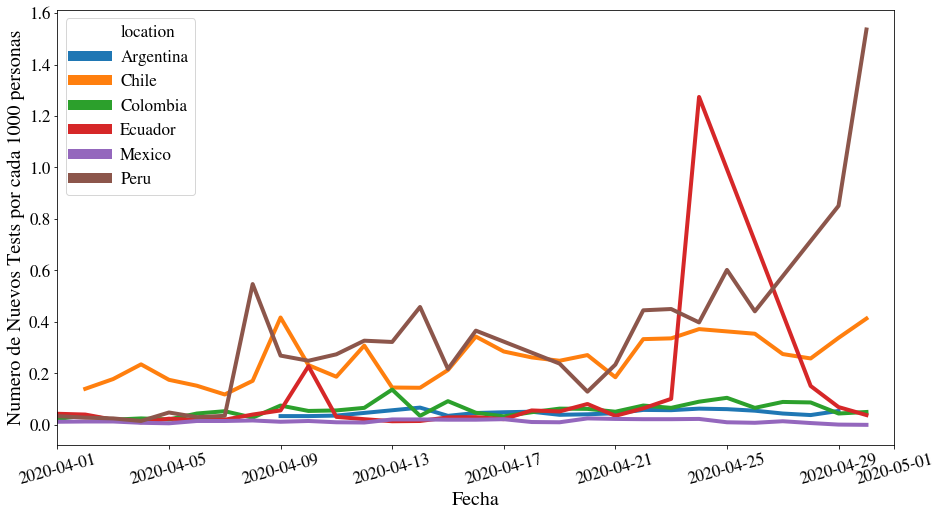

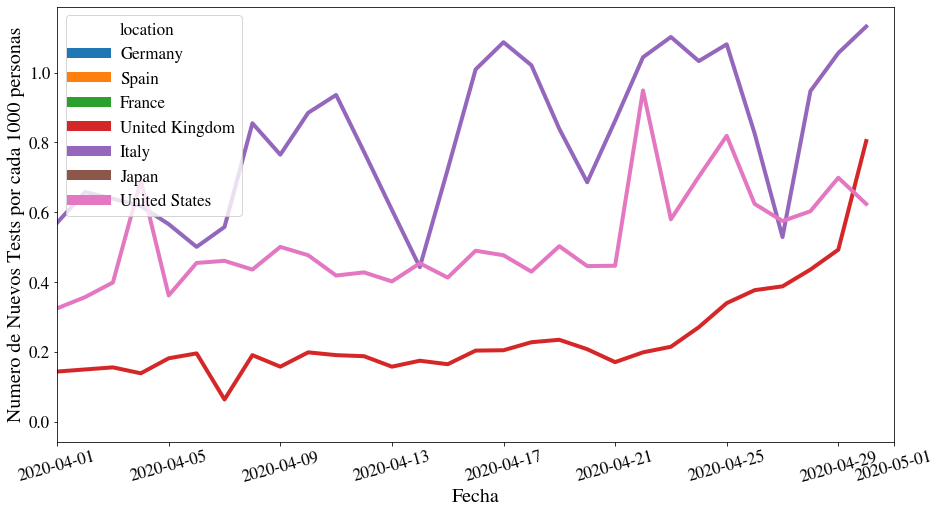

In [52]:
countries_reg = ['Mexico','Colombia','Chile','Peru','Ecuador','Argentina']
plot_new_tests_per_thousand(countries_reg,'Nuevos Tests por miles LATAM',owid_tested,datetime.date(2020,4,15))
# Countries
countries_reg = [ 'Germany'
                 ,'United Kingdom'
                 ,'Italy'
                 ,'France'
                 ,'Spain'
                 ,'United States'
                 ,'Japan']
                 #,'Korea, South']
plot_new_tests_per_thousand(countries_reg,'Nuevos Tests por miles Mundo',owid_tested,datetime.date(2020,2,15))